In [47]:
# GPU scaling lidDrivenCavity
# comparison OF + DIC vs GKO and var. preconditioner
import matplotlib.pyplot as plt
import numpy as np
from import_benchmark_data import import_results
from helpers import idx_query, idx_keep_only, compute_speedup
import pandas as pd

plt.rcParams.update({'font.size': 20})

In [3]:
def line_plot(df, x, columns, facet, properties, 
              fig, axes, kind="line", x_label=None, 
              facet_is_legend=False):
    lines = list(set(df.index.get_level_values(facet)))
    lines.sort()
    default_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    for i, q in enumerate(columns):
        for j,line in enumerate(lines):
            sel = df[df.index.get_level_values(facet) == line]
            sel = idx_keep_only(sel,  keep=[x])
            ax = axes[i]
            legends = properties.get("legends")
            legend = line  if facet_is_legend else False
            f = sel.sort_index().plot(
                legend=True,
                label=legend,
                lw=3,
                ms=10,
                kind=kind,
                ax=ax,
                linestyle=properties.get("linestyle", lambda x: "-")(line),
                marker=properties["marker"](line),
                color=properties.get("color", lambda x: default_colors[j])(line),
            )
            if x_label:
                ax.set_xlabel(x_label[i])
            if legends:
                plt.legend(legends)

In [4]:
def calc_nodes(df, sel, masks):
    df["nodes"] = df.index.get_level_values('mpi_ranks')
    for sel_value, value in masks:
        mask = df.index.get_level_values(sel) == sel_value
        df.loc[mask,"nodes"] = df.loc[mask, "nodes"]/value
    df = df.set_index("nodes", append=True)
    return df

In [120]:
revision = "c17d816b"
campaign = "multi_gpu"
case = "single_node"
path_buffer = "../../results/{}/01_host_buffer/{}/lidDrivenCavity".format(campaign, revision)
path_direct = "../../results/{}/02_gpu_direct/{}/lidDrivenCavity".format(campaign, revision)
path = "../../results/{}/".format(campaign)

In [121]:
# load dfs 

df = import_results(
    path=path_buffer,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]

../../results/multi_gpu/01_host_buffer/c17d816b/lidDrivenCavity/single_node/Logs


In [33]:
np.logical_and(df.index.get_level_values("backend_p") == "PETSC",
          df.index.get_level_values("executor_p") == "HIP")

array([False, False,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True, False, False, False, False,
       False,  True,  True,  True,  True,  True])

/tmp/ipykernel_181/4218179179.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_foam["index"] = "OF"
/tmp/ipykernel_181/4218179179.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_gko["index"] = "GKO-HIP"


../../results/multi_gpu/


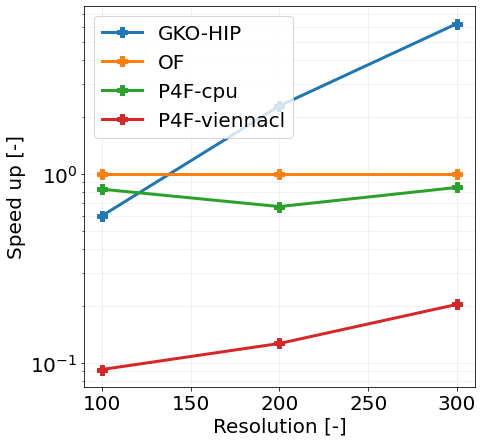

In [122]:
columns = ["linear_solve_p"] 

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]



sel = idx_query(df, 
            [
                ("solver_p", "CG"),
                ("node", "horeka", False),
                ("resolution", 400, False),
                ("mpi_ranks", 0, False),
            ])


sel = sel.drop(["log_id", "timestamp" , "case"] ,axis=1)

speedup = compute_speedup(sel,
            [
             ("executor_p", "Default"),
             ("backend_p", "OpenFOAM"),
            ],
            drop_indices=["node", "mpiRank_of", "processes", "omp_threads", "mpi_ranks"],
            ignore_indices=["mpiRank_gko", "backend_p"]            
            )

res_foam = idx_query(speedup, [("backend_p", "OpenFOAM", True)])
res_foam["index"] = "OF"

res_gko = idx_query(speedup, [("backend_p", "Ginkgo", True)])
res_gko["index"] = "GKO-HIP"

res_viennacl = idx_query(speedup, [("backend_p", "PETSC", True), ("executor_p", "HIP", True)])
res_viennacl["index"] = "P4F-viennacl"

res_petsc_cpu = idx_query(speedup, [("backend_p", "PETSC", True), ("executor_p", "HIP", False)])
res_petsc_cpu["index"] = "P4F-cpu"

for_plot = pd.concat([res_foam,res_gko,res_viennacl,res_petsc_cpu])
for_plot = for_plot.set_index("index", append=True)


line_plot(for_plot["linear_solve_p"], 
        x="resolution", 
        columns=columns, 
        facet="index",
        #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
        fig=fig,
        axes=axes,
        facet_is_legend=True,
        properties={
        #"legends": ["2", "3", "4"],
        "linestyle": lambda x: ls,
        "marker": lambda x: "P",
        "title": lambda x: ["Linear Solve P"][x]
    })

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Resolution [-]")
        ax.set_yscale("log")

print(path)
plt.savefig(path +  "/linear_solve_multi_gpu_vs_single_node_petsc.png", bbox_inches='tight')

In [103]:
sel.loc["CG"].sort_index()

run_time  \
executor_p preconditioner_p resolution omp_threads mpi_ranks node   mpiRank_gko processes backend_p mpiRank_of             
CUDA       NoPrecond        100        1           4         horeka 0.0         1         PETSC     4.0              0.0   
                            200        1           4         horeka 0.0         1         PETSC     4.0              0.0   
                                                                    1.0         1         Ginkgo    0.0              0.0   
                            300        1           4         horeka 0.0         1         PETSC     4.0              0.0   
                                                                    1.0         1         Ginkgo    0.0              0.0   
                            400        1           4         horeka 0.0         1         PETSC     4.0              0.0   
                                                                    1.0         1         Ginkgo    0.0              0.0   
Default    NoPrecond        100        1           76        horeka 0.0         1         OpenFOAM  1.0              0.0   
                                                                                          PETSC     1.0              0.0   
                            200        1           76        horeka 0.0         1         OpenFOAM  1.0              0.0   
                                                                                          PETSC     1.0              0.0   
                            300        1           76        horeka 0.0         1         OpenFOAM  1.0              0.0   
                                                                                          PETSC     1.0              0.0   
                            400        1           76        horeka 0.0         1         OpenFOAM  1.0              0.0   
                                                                                          PETSC     1.0              0.0   

                                                                                                                linear_solve_p  \
executor_p preconditioner_p resolution omp_threads mpi_ranks node   mpiRank_gko processes backend_p mpiRank_of                   
CUDA       NoPrecond        100        1           4         horeka 0.0         1         PETSC     4.0           1.069396e+05   
                            200        1           4         horeka 0.0         1         PETSC     4.0           5.699581e+05   
                                                                    1.0         1         Ginkgo    0.0           9.549469e+05   
                            300        1           4         horeka 0.0         1         PETSC     4.0           2.445677e+06   
                                                                    1.0         1         Ginkgo    0.0           4.241941e+06   
                            400        1           4         horeka 0.0         1         PETSC     4.0           0.000000e+00   
                                                                    1.0         1         Ginkgo    0.0           1.252138e+07   
Default    NoPrecond        100        1           76        horeka 0.0         1         OpenFOAM  1.0           8.346468e+04   
                                                                                          PETSC     1.0           0.000000e+00   
                            200        1           76        horeka 0.0         1         OpenFOAM  1.0           3.171588e+06   
                                                                                          PETSC     1.0           0.000000e+00   
                            300        1           76        horeka 0.0         1         OpenFOAM  1.0           2.622777e+07   
                                                                                          PETSC     1.0           0.000000e+00   
                            400        1           76

/tmp/ipykernel_181/2904955489.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_foam["index"] = "OF"
/tmp/ipykernel_181/2904955489.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_gko["index"] = "GKO-CUDA"


../../results/multi_gpu/


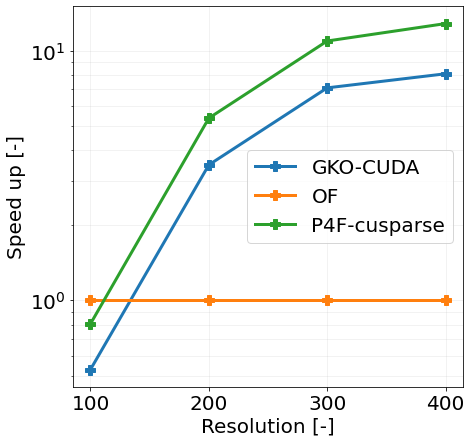

In [125]:
columns = ["linear_solve_p"] 

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]



sel = idx_query(df, 
            [
                ("solver_p", "CG"),
                ("node", "horeka", True),
                #("resolution", 400, False),
                ("mpi_ranks", 0, False),
            ])


sel = sel.drop(["log_id", "timestamp" , "case"] ,axis=1)

sel["linear_solve_p"] = sel["linear_solve_p"]
speedup = compute_speedup(sel,
            [
             ("executor_p", "Default"),
             ("backend_p", "OpenFOAM"),
            ],
            drop_indices=["node", "mpiRank_of", "processes", "omp_threads", "mpi_ranks"],
            ignore_indices=["mpiRank_gko", "backend_p"]            
            )

res_foam = idx_query(speedup, [("backend_p", "OpenFOAM", True)])
res_foam["index"] = "OF"

res_gko = idx_query(speedup, [("backend_p", "Ginkgo", True)])
res_gko["index"] = "GKO-CUDA"

res_viennacl = idx_query(speedup, [("backend_p", "PETSC", True), ("executor_p", "CUDA", True)])
res_viennacl["index"] = "P4F-cusparse"

res_petsc_cpu = idx_query(speedup, [("backend_p", "PETSC", True), ("executor_p", "CUDA", False)])
res_petsc_cpu["index"] = "P4F-cpu"

for_plot = pd.concat([res_foam,res_gko,res_viennacl])
for_plot = for_plot.set_index("index", append=True)



line_plot(for_plot["linear_solve_p"], 
        x="resolution", 
        columns=columns, 
        facet="index",
        #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
        fig=fig,
        axes=axes,
        facet_is_legend=True,
        properties={
        #"legends": ["2", "3", "4"],
        "linestyle": lambda x: ls,
        "marker": lambda x: "P",
        "title": lambda x: ["Linear Solve P"][x]
    })

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Resolution [-]")
        ax.set_yscale("log")

print(path)
plt.savefig(path +  "/linear_solve_multi_gpu_vs_single_node_petsc_cuda_normalised.png", bbox_inches='tight')

In [124]:
sel

run_time  \
solver_p executor_p preconditioner_p resolution omp_threads mpi_ranks node   mpiRank_gko processes backend_p mpiRank_of             
CG       Default    NoPrecond        400        1           76        horeka 0.0         1         PETSC     1.0              0.0   
         CUDA       NoPrecond        400        1           4         horeka 0.0         1         PETSC     4.0              0.0   
                                                                             1.0         1         Ginkgo    0.0              0.0   
         Default    NoPrecond        400        1           76        horeka 0.0         1         OpenFOAM  1.0              0.0   
                                     300        1           76        horeka 0.0         1         PETSC     1.0              0.0   
         CUDA       NoPrecond        300        1           4         horeka 0.0         1         PETSC     4.0              0.0   
                                                                             1.0         1         Ginkgo    0.0              0.0   
         Default    NoPrecond        300        1           76        horeka 0.0         1         OpenFOAM  1.0              0.0   
                                     200        1           76        horeka 0.0         1         PETSC     1.0              0.0   
         CUDA       NoPrecond        200        1           4         horeka 0.0         1         PETSC     4.0              0.0   
                                                                             1.0         1         Ginkgo    0.0              0.0   
         Default    NoPrecond        200        1           76        horeka 0.0         1         OpenFOAM  1.0              0.0   
                                     100        1           76        horeka 0.0         1         PETSC     1.0              0.0   
         CUDA       NoPrecond        100        1           4         horeka 0.0         1         PETSC     4.0              0.0   
                                                                             1.0         1         Ginkgo    0.0              0.0   
         Default    NoPrecond        100        1           76        horeka 0.0         1         OpenFOAM  1.0              0.0   

                                                                                                                         linear_solve_p  \
solver_p executor_p preconditioner_p resolution omp_threads mpi_ranks node   mpiRank_gko processes backend_p mpiRank_of                   
CG       Default    NoPrecond        400        1           76        horeka 0.0         1         PETSC     1.0                    NaN   
         CUDA       NoPrecond        400        1           4         horeka 0.0         1         PETSC     4.0            4108.567740   
                                                                             1.0         1         Ginkgo    0.0            5991.995071   
         Default    NoPrecond        400        1           76        horeka 0.0         1         OpenFOAM  1.0           56571.459384   
                                     300        1           76        horeka 0.0         1         PETSC     1.0                    NaN   
         CUDA       NoPrecond        300        1           4         horeka 0.0         1         PETSC     4.0            1960.762292   
                                                                             1.0         1         Ginkgo    0.0            2916.518775   
         Default    NoPrecond        300        1           76        horeka 0.0         1         OpenFOAM  1.0           23621.342095   
                                     200        1           76        horeka 0.0         1         PETSC     1.0                    NaN   
         CUDA       NoPrecond        200        1           4         horeka 0.0         1         PETSC     4.0             803.291133   
                                                          

/tmp/ipykernel_181/280649640.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_foam["index"] = "OF"
/tmp/ipykernel_181/280649640.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_gko["index"] = "GKO-CUDA"


../../results/multigpu/


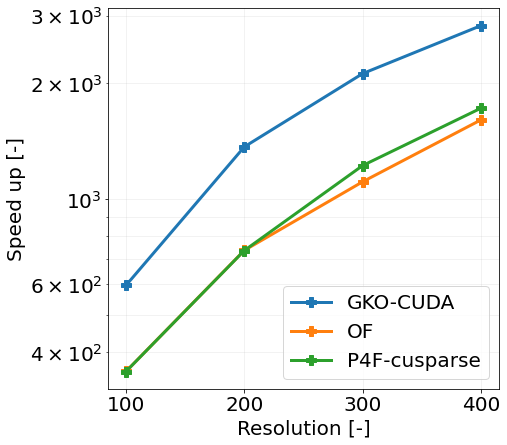

In [112]:
columns = ["linear_solve_p"] 

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]



sel = idx_query(df, 
            [
                ("solver_p", "CG"),
                ("node", "horeka", True),
                #("resolution", 400, False),
                ("mpi_ranks", 0, False),
            ])


sel = sel.drop(["log_id", "timestamp" , "case"] ,axis=1)

speedup = sel 

res_foam = idx_query(speedup, [("backend_p", "OpenFOAM", True)])
res_foam["index"] = "OF"

res_gko = idx_query(speedup, [("backend_p", "Ginkgo", True)])
res_gko["index"] = "GKO-CUDA"

res_viennacl = idx_query(speedup, [("backend_p", "PETSC", True), ("executor_p", "CUDA", True)])
res_viennacl["index"] = "P4F-cusparse"

res_petsc_cpu = idx_query(speedup, [("backend_p", "PETSC", True), ("executor_p", "CUDA", False)])
res_petsc_cpu["index"] = "P4F-cpu"

for_plot = pd.concat([res_foam,res_gko,res_viennacl])
for_plot = for_plot.set_index("index", append=True)



line_plot(for_plot["number_iterations_p"], 
        x="resolution", 
        columns=columns, 
        facet="index",
        #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
        fig=fig,
        axes=axes,
        facet_is_legend=True,
        properties={
        #"legends": ["2", "3", "4"],
        "linestyle": lambda x: ls,
        "marker": lambda x: "P",
        "title": lambda x: ["Linear Solve P"][x]
    })

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Resolution [-]")
        ax.set_yscale("log")

print(path)
plt.savefig(path +  "/linear_solve_multi_gpu_vs_single_node_petsc_cuda_iterations.png", bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: '../../results/multigpu/simple/linear_solve_multi_gpu_vs_single_node.png'

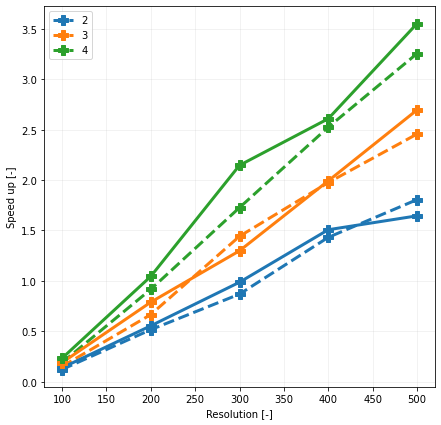

In [12]:
columns = ["linear_solve_p"] 

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

for (df, ls) in zip([df_host, df_direct], ["--","-"]):

    df = idx_query(df, 
            [
                ("solver_p", "CG"),
                ("node", "horeka", True),
            ])


    df = df.drop(["log_id", "timestamp" , "case"] ,axis=1)

    of_data = compute_speedup(df,
            [
             ("executor_p", "DefaultOF")
            ],
            drop_indices=["node", "mpiRank_of", "processes", "omp_threads", "mpi_ranks"],
            ignore_indices=["mpiRank_gko"]                  
            )

    of_data = idx_query(of_data, [
            ("executor_p", "CUDA"),    
        ]).sort_index()


    line_plot(of_data["deltaT"], 
        x="resolution", 
        columns=columns, 
        facet="mpiRank_gko",
        #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
        fig=fig,
        axes=axes,
        facet_is_legend=True,
        properties={
        "legends": ["2", "3", "4"],
        "linestyle": lambda x: ls,
        "marker": lambda x: "P",
        "title": lambda x: ["Linear Solve P"][x]
    })

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Resolution [-]")
        #ax.set_yscale('log')
        #ax.set_xscale('log')

plt.savefig(path + case + "/linear_solve_multi_gpu_vs_single_node.png", bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: '../../results/multigpu/simple/linear_solve_multi_gpu_vs_single_node.png'

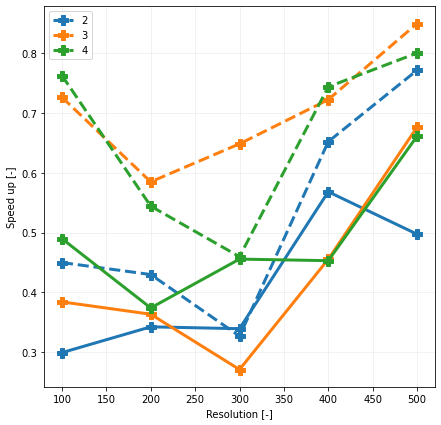

In [13]:


columns = ["linear_solve_p"] 

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

for (df, ls) in zip([df_host, df_direct], ["--","-"]):

    df = idx_query(df, 
            [
                ("solver_p", "CG"),
                ("node", "horeka", True),
            ])


    df = df.drop(["log_id", "timestamp" , "case"] ,axis=1)

    of_data = df

    of_data = idx_query(of_data, [
            ("executor_p", "CUDA"),    
        ]).sort_index()


    line_plot(of_data["linear_solve_p_ratio"], 
        x="resolution", 
        columns=columns, 
        facet="mpiRank_gko",
        #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
        fig=fig,
        axes=axes,
        facet_is_legend=True,
        properties={
        "legends": ["2", "3", "4"],
        "linestyle": lambda x: ls,
        "marker": lambda x: "P",
        "title": lambda x: ["Linear Solve P"][x]
    })

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Resolution [-]")
        #ax.set_yscale('log')
        #ax.set_xscale('log')

plt.savefig(path + case + "/linear_solve_multi_gpu_vs_single_node.png", bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: '../../results/multigpu/simple/linear_solve_multi_gpu_vs_single_node.png'

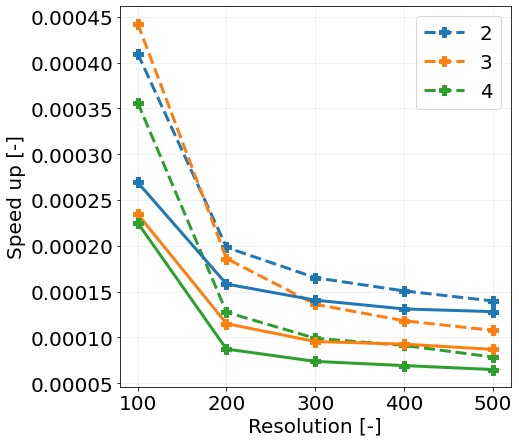

In [23]:
columns = ["linear_solve_p"] 

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

for (df, ls) in zip([df_host, df_direct], ["--","-"]):

    df = idx_query(df, 
            [
                ("solver_p", "CG"),
                ("node", "horeka", True),
            ])


    df = df.drop(["log_id", "timestamp" , "case"] ,axis=1)

    of_data = df

    of_data = idx_query(of_data, [
            ("executor_p", "CUDA"),    
        ]).sort_index()


    line_plot(of_data["linear_solve_p_per_cell_and_iter"], 
        x="resolution", 
        columns=columns, 
        facet="mpiRank_gko",
        #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
        fig=fig,
        axes=axes,
        facet_is_legend=True,
        properties={
        "legends": ["2", "3", "4"],
        "linestyle": lambda x: ls,
        "marker": lambda x: "P",
        "title": lambda x: ["Linear Solve P"][x]
    })

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Resolution [-]")
        #ax.set_yscale('log')
        #ax.set_xscale('log')

plt.savefig(path + case + "/linear_solve_multi_gpu_vs_single_node.png", bbox_inches='tight')

In [7]:
df_host

timestamp  \
solver_p executor_p preconditioner_p resolution omp_threads mpi_ranks node   processes mpiRank_gko mpiRank_of                               
CG       CUDA       NoPrecond        500        1           3         horeka 1         3.0         0.0         2022-06-27 15:00:15.791277   
                                                            2         horeka 1         2.0         0.0         2022-06-27 15:00:15.840643   
                                                            4         horeka 1         4.0         0.0         2022-06-27 15:00:15.867370   
                                     400        1           3         horeka 1         3.0         0.0         2022-06-27 15:00:15.910130   
                                                            2         horeka 1         2.0         0.0         2022-06-27 15:00:15.956392   
                                                            4         horeka 1         4.0         0.0         2022-06-27 15:00:16.007875   
                                     300        1           3         horeka 1         3.0         0.0         2022-06-27 15:00:16.042051   
                                                            2         horeka 1         2.0         0.0         2022-06-27 15:00:16.053900   
                                                            4         horeka 1         4.0         0.0         2022-06-27 15:00:16.067387   
                                     200        1           3         horeka 1         3.0         0.0         2022-06-27 15:00:16.097665   
                                                            2         horeka 1         2.0         0.0         2022-06-27 15:00:16.108515   
                                                            4         horeka 1         4.0         0.0         2022-06-27 15:00:16.119574   
                                     100        1           3         horeka 1         3.0         0.0         2022-06-27 15:00:16.174871   
                                                            2         horeka 1         2.0         0.0         2022-06-27 15:00:16.185416   
                                                            4         horeka 1         4.0         0.0         2022-06-27 15:00:16.196897   
         DefaultOF  NoPrecond        500        1           76        horeka 1         0.0         1.0         2022-06-27 08:31:11.502928   
                                     400        1           76        horeka 1         0.0         1.0         2022-06-27 08:31:11.539226   
                                     300        1           76        horeka 1         0.0         1.0         2022-06-27 08:31:11.592590   
                                     200        1           76        horeka 1         0.0         1.0         2022-06-27 08:31:11.658916   
                                     100        1           76        horeka 1         0.0         1.0         2022-06-27 08:31:11.704838   

                                                                                                                                         log_id  \
solver_p executor_p preconditioner_p resolution omp_threads mpi_ranks node   processes mpiRank_gko mpiRank_of                                     
CG       CUDA       NoPrecond        500        1           3         horeka 1         3.0         0.0         2c361d31e5e7f9639939e2ba202f927c   
                                                            2         horeka 1         2.0         0.0         769e9a4fb6875093c5bfbb92a6c8cd80   
                                                            4         horeka 1         4.0         0.0         aa9933a45ee004121521c53483001089   
                                     400        1           3         horeka 1         3.0         0.0         930d8f8565b1ace6d26d44f150c5a03a   
                                                            2         horeka 1         2.0         0.0         86f07a9becced61b87b94017e1889816

IndexError: list index out of range

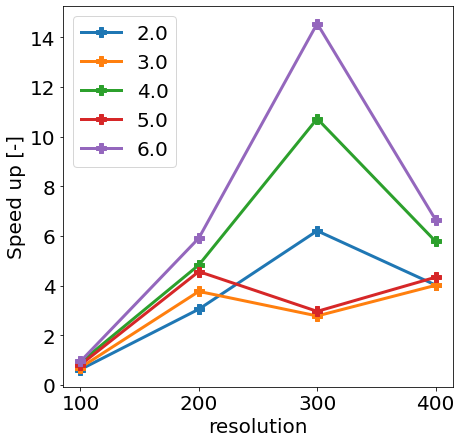

In [31]:


columns = ["linear_solve_p"] 

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

for (df, ls) in zip([df_host], ["-"]):

    df = idx_query(df, 
            [
                ("solver_p", "CG"),
                ("node", "nla", True),
                ("resolution", 500, False),
            ])


    df = df.drop(["log_id", "timestamp" , "case"] ,axis=1)

    of_data = compute_speedup(df,
            [
             ("executor_p", "DefaultOF")
            ],
            drop_indices=["node", "mpiRank_of", "processes", "omp_threads", "mpi_ranks"],
            ignore_indices=["mpiRank_gko"]                  
            )

    of_data = idx_query(of_data, [
            ("executor_p", "HIP"),    
        ]).sort_index()


    line_plot(of_data["linear_solve_p_per_iter"], 
        x="resolution", 
        columns=columns, 
        facet="mpiRank_gko",
        #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
        fig=fig,
        axes=axes,
        facet_is_legend=True,
        properties={
        # "legends": ["2", "3", "4"],
        "linestyle": lambda x: ls,
        "marker": lambda x: "P",
        "title": lambda x: ["Linear Solve P"][x]
    })

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Resolution [-]")

plt.savefig(path +  "/linear_solve_multi_gpu_vs_single_node_nla.png", bbox_inches='tight')

../../results/multigpu/


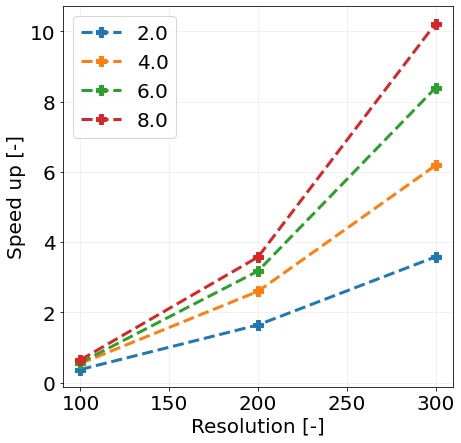

In [49]:


columns = ["linear_solve_p"] 

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

for (df, ls) in zip([df_host], ["--"]):

    df = idx_query(df, 
            [
                ("solver_p", "CG"),
                ("node", "nla", True),
                ("resolution", 500, False),
                ("resolution", 400, False),
                ("mpiRank_gko", 3, False),
                ("mpiRank_gko", 5, False),
                ("mpiRank_gko", 7, False),
            ])


    df = df.drop(["log_id", "timestamp" , "case"] ,axis=1)

    of_data = compute_speedup(df,
           [
             ("executor_p", "DefaultOF")
           ],
           drop_indices=["node", "mpiRank_of", "processes", "omp_threads", "mpi_ranks"],
           ignore_indices=["mpiRank_gko"]                  
           )

    of_data = idx_query(of_data, [
            ("executor_p", "HIP"),    
        ]).sort_index()


    line_plot(of_data["linear_solve_p"], 
        x="resolution", 
        columns=columns, 
        facet="mpiRank_gko",
        #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
        fig=fig,
        axes=axes,
        facet_is_legend=True,
        properties={
        # "legends": ["2", "3", "4"],
        "linestyle": lambda x: ls,
        "marker": lambda x: "P",
        "title": lambda x: ["Linear Solve P"][x]
    })

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Resolution [-]")
print(path)
plt.savefig(path +  "/linear_solve_multi_gpu_vs_single_node_nla.png", bbox_inches='tight')

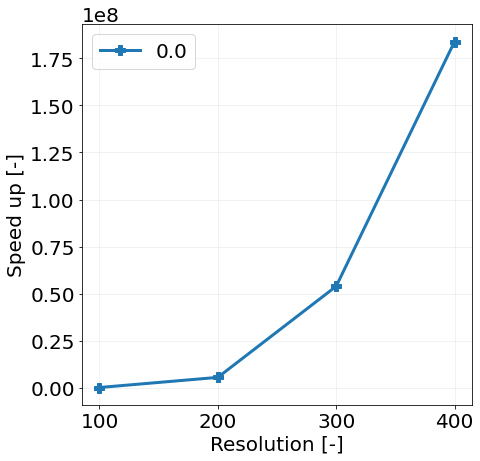

In [38]:


columns = ["linear_solve_p"] 

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

for (df, ls) in zip([df_host], ["-"]):

    df = idx_query(df, 
            [
                ("solver_p", "CG"),
                ("node", "nla", True),
                ("resolution", 500, False),
                ("mpiRank_gko", 3, False),
                ("mpiRank_gko", 5, False),
                ("mpiRank_gko", 7, False),
            ])


    df = df.drop(["log_id", "timestamp" , "case"] ,axis=1)

    of_data = df# compute_speedup(df,
           #[
           #  ("executor_p", "DefaultOF")
           #],
           #drop_indices=["node", "mpiRank_of", "processes", "omp_threads", "mpi_ranks"],
           #ignore_indices=["mpiRank_gko"]                  
           #)

    of_data = idx_query(of_data, [
            ("executor_p", "DefaultOF"),    
        ]).sort_index()


    line_plot(of_data["linear_solve_p"], 
        x="resolution", 
        columns=columns, 
        facet="mpiRank_gko",
        #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
        fig=fig,
        axes=axes,
        facet_is_legend=True,
        properties={
        # "legends": ["2", "3", "4"],
        "linestyle": lambda x: ls,
        "marker": lambda x: "P",
        "title": lambda x: ["Linear Solve P"][x]
    })

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Resolution [-]")

plt.savefig(path +  "/linear_solve_multi_gpu_vs_single_node_nla.png", bbox_inches='tight')

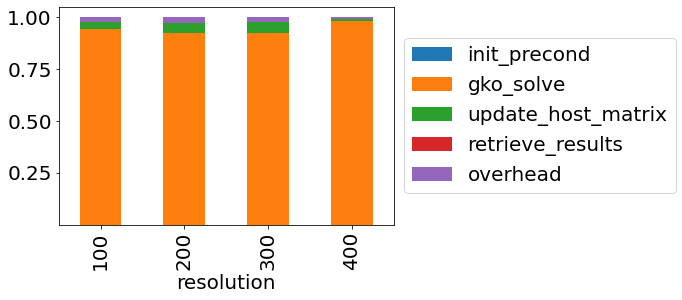

In [47]:
cuda = idx_query(df, 
    [("executor_p", "HIP"),
     ("mpiRank_gko", 8)]           
                )


cuda = cuda[['init_precond', 'gko_solve', 'update_host_matrix', "retrieve_results"]].div(cuda["linear_solve_p"], axis=0)*1000.0
cuda = idx_keep_only(cuda, ["resolution"])

cuda["overhead"] = (1 
        - cuda['init_precond'] 
        - cuda['gko_solve']
        - cuda['update_host_matrix']
        - cuda['retrieve_results']                        
        )

cuda.sort_index().plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig(path +  "/linear_solve_multi_gpu_vs_single_node_nla_breakdown.png", bbox_inches='tight')

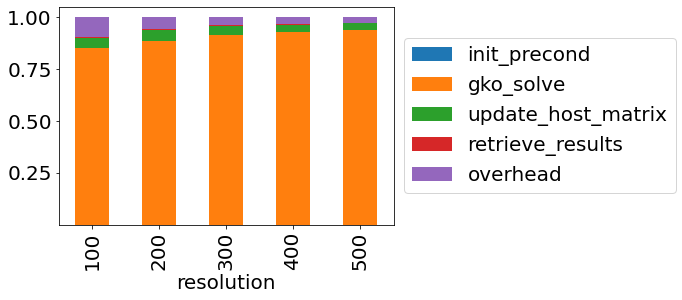

In [21]:
cuda = idx_query(df, 
    [("executor_p", "CUDA"),
     ("mpiRank_gko", 4)]           
                )


cuda = cuda[['init_precond', 'gko_solve', 'update_host_matrix', "retrieve_results"]].div(cuda["linear_solve_p"], axis=0)*1000.0
cuda = idx_keep_only(cuda, ["resolution"])

cuda["overhead"] = (1 
        - cuda['init_precond'] 
        - cuda['gko_solve']
        - cuda['update_host_matrix']
        - cuda['retrieve_results']                        
        )

cuda.sort_index().plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [26]:
df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]

columns = ["linear_solve_p"] 

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
        ])


df = df.drop(["log_id", "timestamp" , "case"] ,axis=1)

of_data = compute_speedup(df,
        [
         ("executor_p", "DefaultOF")
        ],
        drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )

of_data = idx_query(of_data, [
        ("executor_p", "CUDA"),    
    ]).sort_index()

                    
line_plot(of_data["linear_solve_p"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")
        #ax.set_yscale('log')
        #ax.set_xscale('log')

plt.savefig(path + case + "/linear_solve_multi_gpu_vs_single_node.png", bbox_inches='tight')

../../results/c17d816b/lidDrivenCavity/simple/Logs


StopIteration: 

<AxesSubplot:xlabel='nodes'>

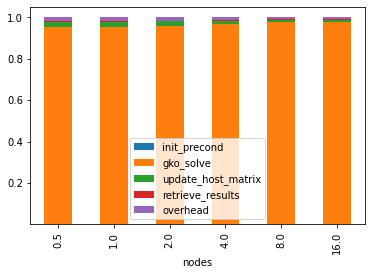

In [27]:
cuda = idx_query(df, 
    [("executor_p", "CUDA"),
     ("resolution", 500)]           
                )
cuda = cuda[['init_precond', 'gko_solve', 'update_host_matrix', "retrieve_results"]].div(cuda["linear_solve_p"], axis=0)
cuda = idx_keep_only(cuda, ["nodes"])

cuda["overhead"] = (1 
        - cuda['init_precond'] 
        - cuda['gko_solve']
        - cuda['update_host_matrix']
        - cuda['retrieve_results']                        
                                )

cuda.sort_index().plot.bar(stacked=True)

<AxesSubplot:xlabel='resolution'>

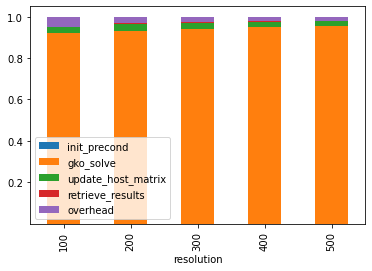

In [28]:
cuda = idx_query(df, 
    [("executor_p", "CUDA"),
     ("nodes", 1)]           
                )
cuda = cuda[['init_precond', 'gko_solve', 'update_host_matrix', "retrieve_results"]].div(cuda["linear_solve_p"], axis=0)
cuda = idx_keep_only(cuda, ["resolution"])

cuda["overhead"] = (1 
        - cuda['init_precond'] 
        - cuda['gko_solve']
        - cuda['update_host_matrix']
        - cuda['retrieve_results']                        
                                )

cuda.sort_index().plot.bar(stacked=True)

In [3]:
fig, axes = plt.subplots(1,
                        len(columns),
                        figsize=(7 * len(columns), 7),
                        sharex=False,
                        sharey=False,
                        gridspec_kw={'wspace': 0.5},
                        subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")
axes = [axes]


for revision, marker, line, cores, case in [
    ("89dc98cf", "P", "-", 64, "simple_host_buffer" ),
    ("f66ef73d","P","-.", 64, "simple")]:
        
    path = "../../results/{}/lidDrivenCavity/".format(revision)
    df = import_results(
            path=path,
            case=case,        
            short_hostname_map={
                "nla": "nla",
                "hkn": "horeka"
            },
            transform_resolution=False
            )["raw"]

    columns = ["linear_solve_p"] 


    df = idx_query(df, 
            [
                ("solver_p", "CG"),
                ("node", "horeka", True),
            ])


    df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)

    df = calc_nodes(df, "executor_p", [("DefaultOF", 64),("CUDA",4)])

    of_data = compute_speedup(df,
            [("nodes", 1),
             ("executor_p", "DefaultOF")
            ],
            drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
            )

    of_data = idx_query(of_data, [
            ("executor_p", "CUDA"),    
        ]).sort_index()


    line_plot(of_data["linear_solve_p"], 
        x="nodes", 
        columns=columns, 
        facet="resolution",
        #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
        fig=fig,
        axes=axes,
        facet_is_legend=True,
        properties={
        #"legends": ["8M", "17M", "34M"],
        "linestyle": lambda x: line,
        "marker": lambda x: marker,
        "title": lambda x: ["Linear Solve P"][x]
    })

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")
        #ax.set_yscale('log')
        #ax.set_xscale('log')

plt.savefig(path + case + "/linear_solve_multi_gpu_vs_single_node.png", bbox_inches='tight')

NameError: name 'columns' is not defined

../../results/89dc98cf/lidDrivenCavity/simple_host_buffer/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


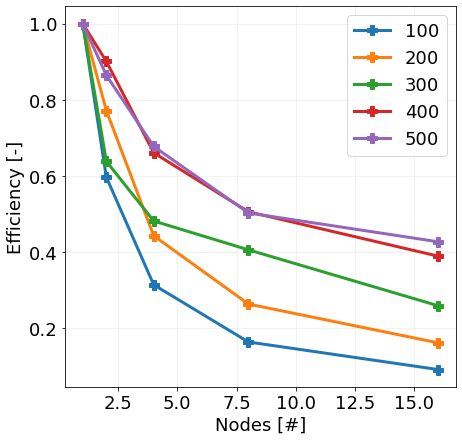

In [40]:

df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]


columns = ["linear_solve_p"] #, "number_iterations_p" ]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Efficiency [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
           # ("resolution", 500, False),
           # ("resolution", b)
        ])

df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df["nodes"] = df.index.get_level_values('mpi_ranks')
df["gpus"] = df.index.get_level_values("mpiRank_gko")

df = calc_nodes(df, "executor_p", [("DefaultOF", 64),("CUDA",4)])

of_data = compute_speedup(df,
        [("nodes", 1),
         ("executor_p", "CUDA")
        ],
        drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )

of_data["efficiency_linear_solve_p_per_iter"] = of_data["linear_solve_p_per_iter"]*of_data["gpus"]

of_data = idx_query(of_data, [
        ("executor_p", "CUDA"),
        ("nodes", 0.5, False),    
    ]).sort_index()

              
line_plot(of_data["efficiency_linear_solve_p_per_iter"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")
        
plt.savefig(path + case + "/efficiency_solve_p_per_iter_multi_gpu_vs_single_node_CUDA.png", bbox_inches='tight')